# Harmonic component separation with and without beam

In [1]:
import numpy as np
import pylab
import healpy as hp
import pysm3 
import pysm3.units as u
import matplotlib.pyplot as py
import cmbdb as cmb


In [2]:
from fgbuster.mixingmatrix import MixingMatrix
from fgbuster.component_model import CMB, Dust, Synchrotron
from fgbuster.separation_recipes import standardize_instrument, _intersect_mask,_get_prewhiten_factors,_A_evaluator,_get_alms,_format_alms,_r_to_c_alms

import fgbuster.algebra as alg
from fgbuster.observation_helpers import get_instrument,get_noise_realization,get_sky,get_observation
from fgbuster.cosmology import _get_Cl_noise

A quick code to verify I'm running the code on a node.

In [3]:
import os
import platform

print("Name:        ", os.name)
print("System:      ", platform.system())
print("Release:     ", platform.release())
print("Architecture:", platform.architecture())
print("Machine:     ", platform.machine())
print("Processor:   ", platform.processor())
print("Release:     ", platform.release())
print("Version:     ", platform.version())

# On Windows:
# nt
# Windows
# 10


if platform.system() != 'Windows':
    print("Uname:       ", os.uname())

# On Windows uname is not available

Name:         posix
System:       Linux
Release:      3.10.0-1127.el7.x86_64
Architecture: ('64bit', 'ELF')
Machine:      x86_64
Processor:    x86_64
Release:      3.10.0-1127.el7.x86_64
Version:      #1 SMP Tue Mar 31 23:36:51 UTC 2020
Uname:        posix.uname_result(sysname='Linux', nodename='ansys06', release='3.10.0-1127.el7.x86_64', version='#1 SMP Tue Mar 31 23:36:51 UTC 2020', machine='x86_64')


Little function to compute $D_{\ell}$

In [4]:
def D_ell(C_ell):
    # Determine the length of the input power spectrum
    n_ell = len(C_ell)

    # Create an array of zeros to store the scale invariant power spectrum
    D_ell = np.zeros(n_ell)

    # Compute the scale invariant power spectrum using vectorized operations
    # Vectorized operations eliminate the need for a for loop, improving performance

    # Compute the product of each element with the next element using np.arange(n_ell) * (np.arange(n_ell) + 1)
    # Multiply the above result by C_ell to perform element-wise multiplication with the corresponding elements in C_ell
    # Divide the above result by np.pi to perform element-wise division by pi
    D_ell = np.arange(n_ell) * (np.arange(n_ell) + 1) * C_ell / np.pi

    # Return the computed scale invariant power spectrum
    return D_ell

# Simulating Sky

In [5]:
nside_in = 128
# lmax = 3*NSIDE-1  # Maximum ell value based on the given NSIDE value
lmax = 2*nside_in
sky_d0s0 = get_sky(nside_in, 'd0s0')  # Get the sky map using the specified NSIDE and sky type 'd0s0'

instrument = get_instrument('LiteBIRD')  # Get the instrument information for 'LiteBIRD'

freq_maps_d0s0 = get_observation(instrument, sky_d0s0)
# Obtain the frequency maps for the given instrument and sky map.
# freq_maps_d0s0 is a 3D array containing the observed maps for each frequency channel.

num_freq, ncomp, npix = freq_maps_d0s0.shape
# Retrieve the dimensions of the freq_maps_d0s0 array.
# - num_freq represents the number of frequency channels.
# - ncomp represents the number of components in the observed map.
# - npix represents the number of pixels in the observed map.

/home/julientang2001/fgbuster/fgbuster/observation_helpers.py:97: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  return df.dropna(1, 'all')


In [6]:

instrument_null = get_instrument('LiteBIRD')
instrument_null.fwhm = np.zeros(15)
print(instrument_null.fwhm)

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
Name: fwhm, dtype: float64


/home/julientang2001/fgbuster/fgbuster/observation_helpers.py:97: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  return df.dropna(1, 'all')


#### Create CMB map

Using Planck 2018, compute a CMB map of specified NSIDE. This will be the input map.
Retrieve the cls from the map. 

In [7]:
cl_CMB_th = hp.read_cl("/home/julientang2001/Stage3A/Cls_Planck2018_lensed_scalar.fits")

cl_CMB_crop_th = cl_CMB_th[:,:lmax+1]

np.random.seed(0)
map_CMB = hp.synfast(cl_CMB_th,nside=nside_in,new = True)


In [8]:
print(cl_CMB_crop_th.shape)

(4, 257)


I compute the power spectrum of the simulated CMB map:

In [9]:
cl_CMB6 = hp.anafast(map_CMB,lmax=lmax,alm = False)
cl_CMB = cl_CMB6[:4]
print(cl_CMB.shape)

(4, 257)


The power spectrum $C_{\ell}$ contains (TT, EE, BB, TE, EB, TB).

In [10]:
print(cl_CMB_th[:,:lmax+1].shape)


(4, 257)


#### Noise maps

We use LiteBIRD specifications to simulate a noise map.

In [11]:
freq_maps_simple_noiseless = np.array([np.add(map_CMB,map_d0s0) for map_d0s0 in freq_maps_d0s0])
np.random.seed(0)

freq_map_noise = get_noise_realization(nside_in,instrument#,unit = 'uK_CMB'
                                       )
# freq_map_noise = np.zeros(freq_maps_simple_noiseless.shape)

amin2rad = np.pi/(60.*180.)

## Beams

For each frequency channel, we compute a polarized beam of specified full width half maximum.

In [12]:
beam_array = np.array([hp.gauss_beam(f*amin2rad,lmax = lmax, pol=True) for f in instrument.fwhm])
print(beam_array.shape)


(15, 257, 4)


The inverse beam is needed for the deconvolution. We also compute the common beam of width 80'.

In [13]:
inv_beam_arr = 1/beam_array
fwhm_common = 80*amin2rad
beam_common = hp.gauss_beam(fwhm_common,lmax = lmax, pol = True)
b_c = np.array([beam_common*beam_inv for beam_inv in inv_beam_arr])
print(b_c.shape)

(15, 257, 4)


In [14]:
print(beam_array.shape)
print(np.where(beam_array[:,:,0]-beam_array[:,:,3]!=0))

(15, 257, 4)
(array([ 0,  0,  0, ..., 14, 14, 14]), array([  0,   1,   2, ..., 254, 255, 256]))


The maps have 3 Stokes parameters $(I,Q,U)$ and span over $n_{pix}$ pixels.
The beams are polarized, contain : (temperature beam,grad/electric polarization beam,curl/magnetic polarization beam, temperature * grad beam).
They cover multipoles up to $l_{max}$.

In [15]:
print(map_CMB.shape,beam_common.shape)

(3, 196608) (257, 4)


#### Smoothing CMB map with common beam

In [16]:
map_CMB_smooth = np.array([hp.smoothing(map_CMB[j,:],beam_window=beam_common[:,j]) for j in range(0,ncomp)])
print(map_CMB_smooth.shape)

map_CMB_smooth_QU =map_CMB_smooth[1:3]
print(map_CMB_smooth_QU.shape)

cl_CMB_smooth = hp.anafast(map_CMB_smooth,lmax=lmax,alm=False)

(3, 196608)
(2, 196608)


In [17]:
alm_CMB_smooth = hp.map2alm(map_CMB_smooth,lmax)

In [18]:
print(alm_CMB_smooth.shape)

(3, 33153)


In [19]:
print(freq_maps_simple_noiseless[0,0].shape)
print(beam_array[0,0].shape)

(196608,)
(4,)


In [20]:
print(instrument)

    frequency  depth_p  depth_i  fwhm  f_sky    status  \
0        40.0    37.42    26.46  70.5    1.0  forecast   
1        50.0    33.46    23.66  58.5    1.0  forecast   
2        60.0    21.31    15.07  51.1    1.0  forecast   
3        68.0    16.87    11.93  47.1    1.0  forecast   
4        78.0    12.07     8.53  43.8    1.0  forecast   
5        89.0    11.30     7.99  41.5    1.0  forecast   
6       100.0     6.56     4.64  37.8    1.0  forecast   
7       119.0     4.58     3.24  33.6    1.0  forecast   
8       140.0     4.79     3.39  30.8    1.0  forecast   
9       166.0     5.57     3.94  28.9    1.0  forecast   
10      195.0     5.85     4.14  28.6    1.0  forecast   
11      235.0    10.79     7.63  24.7    1.0  forecast   
12      280.0    13.80     9.76  22.5    1.0  forecast   
13      337.0    21.95    15.52  20.9    1.0  forecast   
14      402.0    47.45    33.55  17.9    1.0  forecast   

                     reference       type  \
0   arXiv:2202.02773, Tabl

/var/tmp/pbs.172603.idark/ipykernel_109145/3886944222.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = py.cm.get_cmap('viridis')


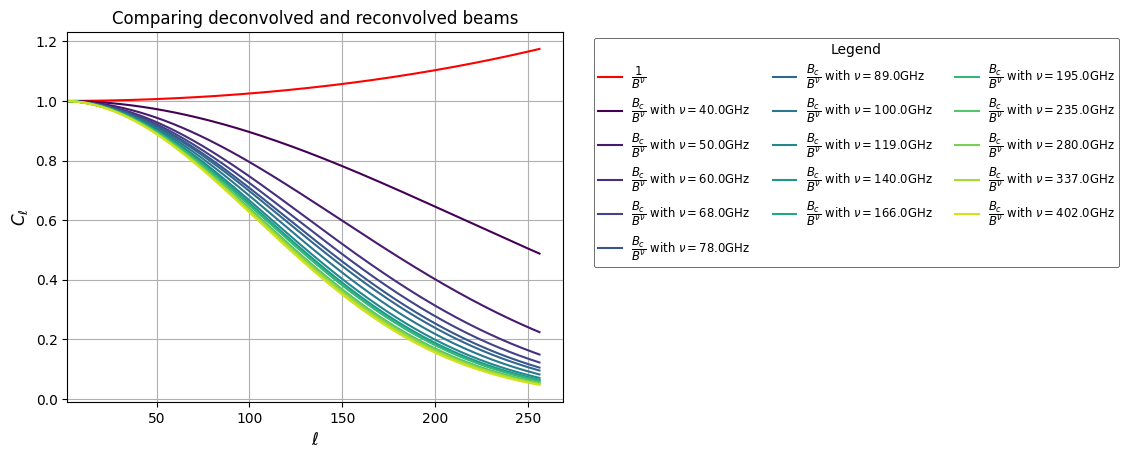

In [21]:
l_arr = np.arange(0, lmax+1, 1)
fig = py.figure()
ax1 = fig.add_subplot(111)
ax1.plot(l_arr, inv_beam_arr[14,:,0], 'r', label='$\dfrac{1}{B^{\\nu}}$')

cmap = py.cm.get_cmap('viridis')
for i in range(15):
    ax1.plot(l_arr, b_c[i,:,0], color=cmap(i/15), label='$\dfrac{B_c}{B^{\\nu}}$ with $\\nu=$'+str(instrument.frequency[i])+'GHz')

ax1.set_xlim(left=2)  # Set the left limit for x-axis

ax1.set_xlabel('$\ell$', fontsize='large')  # Set the x-axis label with small font
ax1.set_ylabel('$C_{\ell}$', fontsize='large')  # Set the y-axis label with small font
ax1.set_title('Comparing deconvolved and reconvolved beams', fontsize='large')  # Set the plot title with small font

ax1.grid(True)  # Enable grid lines

legend = ax1.legend(fontsize='small', loc='best', bbox_to_anchor=(1.05, 1), title='Legend', ncol=3)
legend.get_frame().set_linewidth(0.5)  # Set the linewidth of the legend frame
legend.get_frame().set_edgecolor('black')  # Set the edge color of the legend frame

py.show()  # Display the plot

#### Beaming maps
We want to compute $(B \ast As+n)_p$.
We start with convolution of the noiseless signal.

In [22]:
BAS_p_nl_smooth = np.array([np.array([hp.smoothing(freq_maps_simple_noiseless[i,j],beam_window=beam_array[i,:,j]) for j in range(0,ncomp) ]) for i in range(0,num_freq)])
print(BAS_p_nl_smooth.shape)

(15, 3, 196608)


Then we add the noise

In [23]:
BAS_p = np.add(BAS_p_nl_smooth,freq_map_noise)


Let us compare $\frac{1}{B^{\nu}}(B^{\nu}  \ast A^{\nu} s+n)_p$ and $\frac{B^{c}}{B^{\nu}}(B^{\nu}  \ast A^{\nu} s+n)_p$.

In [24]:
AS_p_inv = np.array([np.array([hp.smoothing(BAS_p[i,j],beam_window=inv_beam_arr[i,:,j]) for j in range(0,ncomp) ]) for i in range(0,num_freq)])

AS_p_ren = np.array([np.array([hp.smoothing(BAS_p[i,j],beam_window=b_c[i,:,j]) for j in range(0,ncomp) ]) for i in range(0,num_freq)])

In [25]:
print(AS_p_inv.shape)

(15, 3, 196608)


### Noise covariance matrices

In [26]:
def invN(instrument, window, num_lm, real=True):
    # Check if window is a NumPy array
    assert isinstance(window, np.ndarray), "Window must be a NumPy array"
    # Check if window has the last dimension equal to 4
    assert window.shape[-1] == 4, "Window last dimension must be 4"

    # Calculate the noise power spectrum
    nl = np.array([1 / (window[..., i] * np.radians(instrument.depth_p / 60.)[:, np.newaxis]) ** 2 for i in range(4)])

    # Get the ell values for the given number of lm modes
    ell = hp.Alm.getlm(lmax, np.arange(num_lm))[0]
    
    # Reshape ell for transformation into real alms if real=True
    if real:
        ell = np.stack((ell, ell), axis=-1).reshape(-1)

    num_stokes = nl.shape[0]
    invN_lm = nl[:, :, ell]

    # Create diagonal matrices from the invN_lm values
    invN_diag_lm = np.array([[np.diag(invN_lm[j, :, i]) for i in range(np.size(ell))] for j in range(num_stokes)])
    invN_diag_lm = np.transpose(invN_diag_lm, (1, 0, 2, 3))

    return invN_diag_lm


In [27]:
def invN_l(instrument, window, lmax, real=True):
    # Check if window is a NumPy array
    assert isinstance(window, np.ndarray), "Window must be a NumPy array"
    # Check if window has the last dimension equal to 4
    assert window.shape[-1] == 4, "Window last dimension must be 4"

    # Calculate the noise power spectrum
    nl = np.array([1 / (window[..., i] * np.radians(instrument.depth_p / 60.)[:, np.newaxis]) ** 2 for i in range(4)])

    # Get the ell values 
    ell = np.arange(lmax+1)

    num_freq, num_l, num_stokes = beam_array.shape
    invN_lm = nl[:,:,ell]
    invN_diag_lm = np.array([[np.diag(invN_lm[j,:,i]) for i in range(0,np.size(ell))]for j in range(0,num_stokes)])
    invN_diag_lm = np.transpose(invN_diag_lm, (1, 0, 2, 3))
    return (invN_diag_lm)


We compute the number of $a_{\ell m}$

In [28]:
alms = _get_alms(AS_p_inv, lmax=lmax)
num_lm = alms.shape[-1]
print(num_lm)

33153


In [29]:
invN_inv = invN(instrument,window = inv_beam_arr,num_lm=num_lm)
inv_ren = invN(instrument,window = b_c,num_lm=num_lm)

/var/tmp/pbs.172603.idark/ipykernel_109145/1226510151.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  nl = np.array([1 / (window[..., i] * np.radians(instrument.depth_p / 60.)[:, np.newaxis]) ** 2 for i in range(4)])


In [30]:
print(invN_inv.shape)


(66306, 4, 15, 15)


## Component separation

Components are CMB, Dust and Synchrotron.

In [31]:
components = [CMB(), Dust(353.), Synchrotron(23.)]

In [32]:
print('As_p_inv[:,1:3,:].shape='+str(AS_p_inv[:,1:3,:].shape))
print('invN_inv[1:3].shape='+str(invN_inv[:,1:3,:,:].shape))
print(AS_p_inv.shape)

As_p_inv[:,1:3,:].shape=(15, 2, 196608)
invN_inv[1:3].shape=(66306, 2, 15, 15)
(15, 3, 196608)


In [33]:
# The starting point of the fit is the ax1sm default value, so let's shift it
components[1].defaults = [1.54, 20.]
components[2].defaults = [-3.0]
A = MixingMatrix(*components) ##Matrix evaluator
comp_params = A.comp_of_dB
A_eval = A.evaluator(instrument.frequency)
i_cmb = A.components.index('CMB')

In [34]:
def _mtm(m, n,OPTIMIZE = False):
    return np.einsum('...ji,...ki->...jk', m, n, optimize=OPTIMIZE)

In [35]:
#Added by Clement Leloup
def harmonic_comp_sep(components, instrument, data, nside, lmax, invN=None,invNlm=None, mask=None, **minimize_kwargs):

    """ Harmonic component separation

    Parameters
    ----------
    components: list
        List storing the :class:`Component` s of the mixing matrix
    instrument:
        Object that provides the following as a key or an attribute.

        - **frequency**
        - **depth_i** or **depth_p** (optional, frequencies are inverse-noise
          weighted according to these noise levels)

        They can be anything that is convertible to a float numpy array.
    data: ndarray or MaskedArray
        Data vector to be separated. Shape *(n_freq, ..., n_pix).*
        *...* can be

        - absent or 1: temperature maps
        - 2: polarization maps
        - 3: temperature and polarization maps (see note)
    nside: int
        For each pixel of a HEALPix map with this nside, the non-linear
        parameters are estimated independently        
    lmax: int
        maximum multipole to use in the likelihood
    invN: ndarray
        estimated noise inverse covariance matrix. Shape *(n_freq, ..., n_lm)*
    mask: ndarray
        mask to be applied before going to harmonic domain, if any.

    Returns
    -------
    result: dict
        It includes

        - **param**: *(list)* - Names of the parameters fitted
        - **x**: *(ndarray)* - ``x[i]`` is the best-fit (map of) the *i*-th
          parameter
        - **Sigma**: *(ndarray)* - ``Sigma[i, j]`` is the (map of) the
          semi-analytic covariance between the *i*-th and the *j*-th parameter.
          It is meaningful only in the high signal-to-noise regime and when the
          *cov* is the true covariance of the data
        - **s**: *(ndarray)* - Component amplitude alms
        - **mask_good**: *(ndarray)* - mask of the entries actually used in the
          component separation

    Note
    ----

    * At the moment, only work with polarization (E AND B modes)

    """

    
    #instrument = standardize_instrument(instrument)
    #lmax = 3 * nside - 1
    n_comp = len(components)
    fsky = 1.0
    
    print('Computing alms')
    try:
        assert np.any(instrument.fwhm)
    except (KeyError, AssertionError):
        beams = None
    else:  # Deconvolve the beam
        beams = instrument.fwhm

    #alms_unmasked = _get_alms(data, beams, lmax=lmax)
    alms_unmasked = _get_alms(data, lmax=lmax)
    
    if mask is not None:
        data_masked = np.asarray([hp.alm2map(alms_unmasked[f], nside) for f in range(len(instrument.frequency))])
        data_masked *= mask
        fsky = float(mask.sum()) / mask.size
        alms = _get_alms(data_masked, lmax=lmax)[:,1:,:] # Here we take only polarization
    else:
        alms = alms_unmasked[:,1:,:] # Here we take only polarization
        
    cl_in = np.array([hp.alm2cl(alm) for alm in alms])
    ell = hp.Alm.getlm(lmax, np.arange(alms.shape[-1]))[0]
    ell = np.stack((ell, ell), axis=-1).reshape(-1) # For transformation into real alms
    #mask_lmin = [l < lmin for l in ell]

    if invNlm is None:
        if invN is not None:
            ell_em = hp.Alm.getlm(lmax, np.arange(alms.shape[-1]))[0]
            ell_em = np.stack((ell_em, ell_em), axis=-1).reshape(-1) # Because we use real alms
            invNlm = np.array([invN[l,1:,:,:] for l in ell_em]) # Here we take only polarization
        else:
            invNlm = None

    #Format alms to be used in comp sep
    alms = _format_alms(alms)

    
    A_ev, A_dB_ev, comp_of_param, x0, params = _A_evaluator(components, instrument)
    if not len(x0):
        A_ev = A_ev()

    # Component separation
    res = alg.comp_sep(A_ev, alms, invNlm, A_dB_ev, comp_of_param, x0, **minimize_kwargs)

    # Craft output
    # 1) Apply the mask, if any
    # 2) Restore the ordering of the input data (pixel dimension last)
    res.params = params
    res.s = np.swapaxes(res.s, 0, 2)
    res.s[res.s == hp.UNSEEN] = 0.
    #res.s = np.asarray(res.s, order='C').view(np.complex128)
    res.s = _r_to_c_alms(res.s)
    cl_out = np.array([hp.alm2cl(alm) for alm in res.s])
    res.cl_in = cl_in/fsky
    res.cl_out = cl_out/fsky
    res.fsky = fsky
    res.chi = res.chi.T
    if 'chi_dB' in res:
        for i in range(len(res.chi_dB)):
            res.chi_dB[i] = res.chi_dB[i].T
    if nside and len(x0):
        res.x = res.x.T
        res.Sigma = res.Sigma.T

    return res


In [36]:
result_beam_inv = harmonic_comp_sep(components,instrument,AS_p_inv,nside =nside_in,lmax = lmax,invNlm=invN_inv[:,1:3,:,:])
# result_beam_inv = harmonic_comp_sep(components,instrument,AS_p_inv,nside =NSIDE,lmax = lmax)


Computing alms


/home/julientang2001/fgbuster/fgbuster/mixingmatrix.py:187: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  res += [g[..., np.newaxis]
/home/julientang2001/fgbuster/fgbuster/mixingmatrix.py:187: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  res += [g[..., np.newaxis]
/home/julientang2001/fgbuster/fgbuster/mixingmatrix.py:187: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  res += [g[..., np.newaxis]
/home/julientang2001/fgbuster/fgbuster/mixingmatrix.py:187: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future versi

In [37]:
result_beam_ren = harmonic_comp_sep(components,instrument,AS_p_ren,nside =nside_in,lmax = lmax,invNlm=inv_ren[:,1:3,:,:])
# result_beam_ren = harmonic_comp_sep(components,instrument,AS_p_ren,nside =NSIDE,lmax = lmax)



Computing alms


/home/julientang2001/fgbuster/fgbuster/mixingmatrix.py:187: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  res += [g[..., np.newaxis]
/home/julientang2001/fgbuster/fgbuster/mixingmatrix.py:187: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  res += [g[..., np.newaxis]
/home/julientang2001/fgbuster/fgbuster/mixingmatrix.py:187: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  res += [g[..., np.newaxis]
/home/julientang2001/fgbuster/fgbuster/mixingmatrix.py:187: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future versi

We compute $W\equiv \left ( A^T N^{-1}A \right ) ^{-1}A^T N^{-1}$

In [38]:
W_mat_ren = alg.W(A_eval(result_beam_ren.x),invN=invN_l(instrument,window=b_c,lmax=lmax))
print(W_mat_ren.shape)

(257, 4, 3, 15)


/var/tmp/pbs.172603.idark/ipykernel_109145/3573137089.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  nl = np.array([1 / (window[..., i] * np.radians(instrument.depth_p / 60.)[:, np.newaxis]) ** 2 for i in range(4)])


We can then compute the effective beam after componengt separation : $B_{eff}=W \frac{B_c}{B_{\nu}}$

In [39]:
beam_eff_CMB = np.array([np.array([np.array([np.dot(W_mat_ren[l,i,j,:],b_c[:,l,i+1]) for i in range(2)]) for j in range(3)]) for l in range(lmax+1)])
print(beam_eff_CMB.shape)

(257, 3, 2)


In [40]:
W_mat_inv = alg.W(A_eval(result_beam_inv.x),invN=invN_l(instrument,window=inv_beam_arr,lmax=lmax))
print(W_mat_inv.shape)

(257, 4, 3, 15)


/var/tmp/pbs.172603.idark/ipykernel_109145/3573137089.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  nl = np.array([1 / (window[..., i] * np.radians(instrument.depth_p / 60.)[:, np.newaxis]) ** 2 for i in range(4)])


In [41]:
print(inv_beam_arr.shape)
inv_beam2 = inv_beam_arr.swapaxes(0,1).swapaxes(1,2)
print(inv_beam2.shape)

(15, 257, 4)
(257, 4, 15)


In [42]:
def _mv(m, v):
    return np.einsum('...ij,...j->...i', m, v, optimize=False)

In [43]:
beam_inv_eff = _mv(W_mat_inv,inv_beam2)
print(beam_inv_eff.shape)

(257, 4, 3)


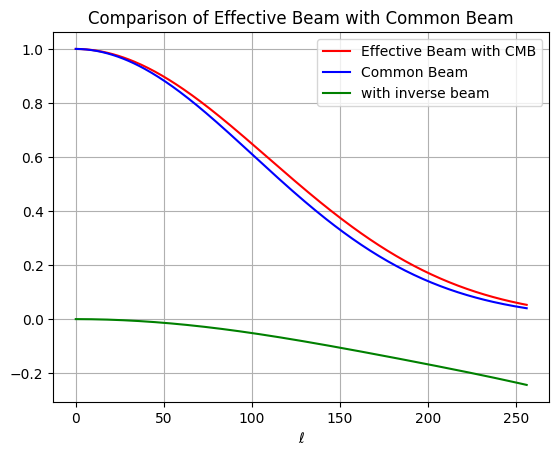

In [44]:
# Plot the curves
py.plot(l_arr, beam_eff_CMB[:, 0, 1], 'r', label='Effective Beam with CMB')
py.plot(l_arr, beam_common[:, 2], 'b', label='Common Beam')
py.plot(beam_inv_eff[:,0,1],'g', label ='with inverse beam')
# Set the x-axis label
py.xlabel('$\ell$')

# Set the title
py.title('Comparison of Effective Beam with Common Beam')

# Show the legend
py.legend()
py.grid()
# Display the plot
py.show()

We can divide the result of the component separation on the reconvolved data by the effective beam

In [45]:
# result_beam_ren.s = np.array([np.array([hp.almxfl(result_beam_ren.s[i,j,:],1/beam_eff_CMB[:,0,j]) for j in range (2)] )for i in  range(3)])


Noise beamed by effective beam

In [46]:
print(freq_map_noise.shape)
print(W_mat_ren.shape)
print(lmax)
print(num_lm)

(15, 3, 196608)
(257, 4, 3, 15)
256
33153


We convolve the noise by the common beam over true beam

In [47]:
noise_map_ren = np.array([np.array([hp.smoothing(freq_map_noise[i,j],beam_window=b_c[i,:,j]) for j in range(0,ncomp) ]) for i in range(0,num_freq)])
noise_map_inv = np.array([np.array([hp.smoothing(freq_map_noise[i,j],beam_window=inv_beam_arr[i,:,j]) for j in range(0,ncomp) ]) for i in range(0,num_freq)])

In [48]:
noise_alm_arr = np.array([hp.map2alm(map_noise,lmax=lmax) for map_noise in noise_map_ren])
noise_alm_inv = np.array([hp.map2alm(map_noise,lmax=lmax) for map_noise in noise_map_inv])
noise_alm_EB = noise_alm_arr[:,1:3,:]
noise_alm_EB = noise_alm_EB.transpose()
print(noise_alm_EB.shape)
noise_alm_inv_EB = noise_alm_inv[:,1:3,:]
noise_alm_inv_EB = noise_alm_inv_EB.transpose()
print(noise_alm_inv_EB.shape)

(33153, 2, 15)
(33153, 2, 15)


We extend W to all $\ell m$

In [49]:
ell_tot = hp.Alm.getlm(lmax, np.arange(num_lm))[0]
Wlm_ren = W_mat_ren[ell_tot,:,:,:]

print(ell_tot.shape)
print(Wlm_ren.shape)

Wlm_ren = Wlm_ren[:,1:3,:,:]
print(Wlm_ren.shape)

(33153,)
(33153, 4, 3, 15)
(33153, 2, 3, 15)


In [50]:
Wlm_inv = W_mat_inv[ell_tot,:,:,:]

print(ell_tot.shape)
print(Wlm_inv.shape)

Wlm_inv = Wlm_inv[:,1:3,:,:]
print(Wlm_inv.shape)

(33153,)
(33153, 4, 3, 15)
(33153, 2, 3, 15)


Quick einstein Summation

In [51]:
def _mv(m, v):
    return np.einsum('...ij,...j->...i', m, v, optimize=False)

In [52]:
noise_alm_eff_ren = _mv(Wlm_ren,noise_alm_EB)
print(noise_alm_eff_ren.shape)
print(type(noise_alm_eff_ren))
noise_alm_eff_ren = noise_alm_eff_ren.swapaxes(0,2)
print(noise_alm_eff_ren.shape)

(33153, 2, 3)
<class 'numpy.ndarray'>
(3, 2, 33153)


In [53]:
noise_alm_eff_inv = _mv(Wlm_ren,noise_alm_inv_EB)
print(noise_alm_eff_inv.shape)
print(type(noise_alm_eff_inv))
noise_alm_eff_inv = noise_alm_eff_inv.transpose()
print(noise_alm_eff_inv.shape)

(33153, 2, 3)
<class 'numpy.ndarray'>
(3, 2, 33153)


For each component, I have the E and B $a_{\ell,m}$

In [54]:
print(AS_p_inv.shape)

(15, 3, 196608)


In [55]:
AS_lm_ren = np.array([hp.map2alm(map_freq,lmax=lmax) for map_freq in AS_p_ren])
AS_lm_EB = AS_lm_ren[:,1:3,:]
AS_lm_EB = AS_lm_EB.transpose()
print(AS_lm_EB.shape)

(33153, 2, 15)


In [56]:
resultat_W=  _mv(Wlm_ren,AS_lm_EB)
resultat_W = resultat_W.swapaxes(0,2)
print(resultat_W.shape)

(3, 2, 33153)


In [57]:
AS_lm_inv = np.array([hp.map2alm(map_freq,lmax=lmax) for map_freq in AS_p_inv])
AS_lm_EB_inv = AS_lm_inv[:,1:3,:]
AS_lm_EB_inv = AS_lm_EB_inv.transpose()
print(AS_lm_EB_inv.shape)

(33153, 2, 15)


In [58]:
resultat_W_inv=  _mv(Wlm_inv,AS_lm_EB_inv)
resultat_W_inv = resultat_W_inv.swapaxes(0,2)
print(resultat_W_inv.shape)

(3, 2, 33153)


Computing the power spectra

In [59]:
resultat_W_cl = np.array([hp.alm2cl(resul_alm) for resul_alm in resultat_W])
noise_cl_eff = np.array([hp.alm2cl(noise_alm) for noise_alm in noise_alm_eff_ren])

In [60]:
print(resultat_W_cl.shape)
print(noise_cl_eff.shape)


(3, 3, 257)
(3, 3, 257)


In [61]:
resultat_W_cl_inv = np.array([hp.alm2cl(resul_alm) for resul_alm in resultat_W_inv])
noise_cl_eff_inv = np.array([hp.alm2cl(noise_alm) for noise_alm in noise_alm_eff_inv])

### Get noise

We now want to retrieve the noise from both component separations.

In [62]:
A_beam_inv = A_eval(result_beam_inv.x)
A_beam_ren = A_eval(result_beam_ren.x)
print(A_beam_ren.shape)
print(A_beam_inv.shape)

(15, 3)
(15, 3)


I have rewritten a function to retrieve the noise power spectrum with input a window function. The previous function worked only with unpolarized gaussian beams.

In [63]:
def _get_Cl_noise_nofwhm(instrument,window, A, lmax):
    if (window.shape[-1]==4):
        temp = 1/window
        nl =np.array([(temp[...,i]/np.radians(instrument.depth_p/60.)[:, np.newaxis])**2 for i in range(4)])
        AtNA = np.array([ np.einsum('...fi,...fl,...fj -> ...lij', A, nl[i], A) for i in range(4)])
        inv_AtNA = np.linalg.inv(AtNA)
        return inv_AtNA.swapaxes(-4, -2).swapaxes(-3,-1)
    else:
        try:
            bl = np.array([hp.gauss_beam(np.radians(b/60.), lmax=lmax,pol=False)
                            for b in instrument.fwhm])
        except AttributeError:
            bl = np.ones((len(instrument.frequency), lmax+1))
        nl = (bl/(window* np.radians(instrument.depth_p/60.)[:, np.newaxis]))**2
    
        AtNA = np.einsum('...fi, ...fl, ...fj ->...lij', A, nl, A)
        inv_AtNA = np.linalg.inv(AtNA)
        return inv_AtNA.swapaxes(-3, -1)

In [64]:

b_c2 = np.zeros(b_c.shape)
print(b_c2[:,:,1:3].shape)
print(beam_eff_CMB.shape)
b_c2[:,:,1:3] = np.array([np.array([(b_c[freq,:,i+1])/(beam_eff_CMB[:,0,i]) for i in range(2)]) for freq in range(num_freq)]).swapaxes(1,2)
print(b_c2.shape)


(15, 257, 2)
(257, 3, 2)
(15, 257, 4)


In [65]:
cl_beam_inv =_get_Cl_noise_nofwhm(instrument=instrument,window = inv_beam_arr,A = A_beam_inv,lmax=lmax)[i_cmb, i_cmb, :]
cl_beam_ren =_get_Cl_noise_nofwhm(instrument=instrument,window = b_c, A = A_beam_ren,lmax=lmax)[i_cmb, i_cmb]
print(cl_beam_ren.shape)
print(cl_beam_inv.shape)

(4, 257)
(4, 257)


/var/tmp/pbs.172603.idark/ipykernel_109145/859232696.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  nl =np.array([(temp[...,i]/np.radians(instrument.depth_p/60.)[:, np.newaxis])**2 for i in range(4)])


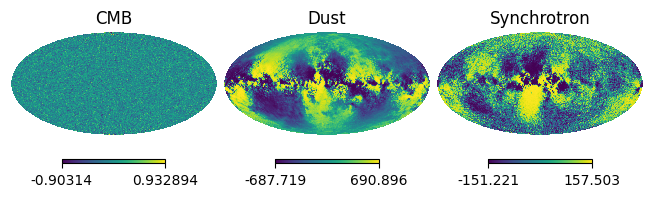

In [66]:
hp.mollview(hp.alm2map(result_beam_inv.s[0,1],nside_in,lmax), title='CMB', sub=(1,3,1))
hp.mollview(hp.alm2map(result_beam_inv.s[1,1],nside_in,lmax), title='Dust', norm='hist', sub=(1,3,2))
hp.mollview(hp.alm2map(result_beam_inv.s[2,1],nside_in,lmax), title='Synchrotron', norm='hist', sub=(1,3,3))


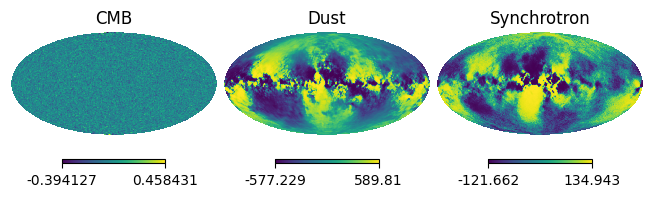

In [67]:

hp.mollview(hp.alm2map(result_beam_ren.s[0,1],nside_in,lmax), title='CMB', sub=(1,3,1))
hp.mollview(hp.alm2map(result_beam_ren.s[1,1],nside_in,lmax), title='Dust', norm='hist', sub=(1,3,2))
hp.mollview(hp.alm2map(result_beam_ren.s[2,1],nside_in,lmax), title='Synchrotron', norm='hist', sub=(1,3,3))

We compare retrieved CMB maps, with input CMB maps.

# Residuals


In [68]:
beam_eff = np.zeros((lmax+1,3))
beam_eff[:,1:3] = beam_eff_CMB[:,0,0:2]
print(beam_eff.shape)

alm_CMB = hp.map2alm(map_CMB,lmax)
print(alm_CMB.shape)


(257, 3)
(3, 33153)


In [69]:
print(noise_alm_eff_ren.shape)

(3, 2, 33153)


In [70]:
print(noise_alm_eff_inv.shape)

(3, 2, 33153)


In [71]:


print(alm_CMB.shape)
print(result_beam_inv.s[0,0:2].shape)
res_CMB_alm_inv = result_beam_inv.s[0,0:2]-alm_CMB[1:3]-noise_alm_eff_inv[0]
res_CMB_alm_ren = result_beam_ren.s[0,0:2]-alm_CMB_smooth[1:3]-noise_alm_eff_ren[0]
# res_CMB_alm_inv = result_beam_inv.s[0,0:2]-alm_CMB[1:3]
# res_CMB_alm_ren = result_beam_ren.s[0,0:2]-alm_CMB_smooth[1:3]
print(res_CMB_alm_ren.shape)

(3, 33153)
(2, 33153)
(2, 33153)


In [72]:
C_l_CMB_inv=hp.alm2cl(res_CMB_alm_inv,lmax=lmax)
C_l_CMB_ren=hp.alm2cl(res_CMB_alm_ren,lmax=lmax)
print(C_l_CMB_inv.shape)
C_EE_CMB_inv_l = C_l_CMB_inv[0]
C_BB_CMB_inv_l = C_l_CMB_inv[1]
C_EE_CMB_ren_l = C_l_CMB_ren[0]
C_BB_CMB_ren_l = C_l_CMB_ren[1]
print(C_EE_CMB_inv_l.shape)

(3, 257)
(257,)


Residual + theoretical input

In [73]:
CMB_lm_res_and_th_ren = alm_CMB[1:3]

### Retrieved CMB Power spectrum


We use the maps to retrieve the power spectrum.


In [74]:
# pixel_window=hp.gauss_beam(hp.nside2resol(NSIDE),lmax=lmax,pol=True)
# print(pixel_window.shape)
# # hp.almxfl(result_beam_inv.s[0,0],pixel_window[:,1])
# # print(hp.almxfl(result_beam_inv.s[0,0],pixel_window[:,1]).shape)
# result_beam_inv.s = np.array([np.array([hp.almxfl(result_beam_inv.s[i,j,:],1/pixel_window[:,j+1]) for j in range (2)] )for i in  range(3)])
# # inter = np.array([hp.almxfl(result_beam_inv.s[i,:,:],pixel_window[:,1:3]) for i in  range(3)])
# result_beam_ren.s = np.array([np.array([hp.almxfl(result_beam_ren.s[i,j,:],1/pixel_window[:,j+1]) for j in range (2)] )for i in  range(3)])


In [75]:
C_L_ren = hp.alm2cl(result_beam_ren.s[0,0:2],lmax=lmax)
print(C_L_ren.shape)
C_l_ren_BB = C_L_ren[1]
print(C_l_ren_BB.shape)
C_L_inv = hp.alm2cl(result_beam_inv.s[0,0:2],lmax=lmax)
print(C_L_inv.shape)
C_l_inv_BB = C_L_inv[1]
print(C_l_inv_BB.shape)

(3, 257)
(257,)
(3, 257)
(257,)


# + Gravitational waves


We now want to compare with the power spectrum of gravitational waves


In [76]:


cl_GW = hp.read_cl("/home/julientang2001/Stage3A/Cls_Planck2018_unlensed_scalar_and_tensor_r1.fits")
print(cl_GW.shape)
cl_GW_crop = cl_GW[:,:lmax+1]
print(cl_GW_crop.shape)

map_CMB = hp.synfast(cl_GW,nside=nside_in)
cl_tot_th = np.add(0.001*cl_GW_crop,cl_CMB_crop_th)
print(cl_beam_ren[2].shape)
print(beam_common[:,2].shape)



(4, 4101)
(4, 257)
(257,)
(257,)


In [77]:
C_EE_CMB_inv_l = C_l_CMB_inv[0]
C_BB_CMB_inv_l = C_l_CMB_inv[1]
C_EE_CMB_ren_l = C_l_CMB_ren[0]
C_BB_CMB_ren_l = C_l_CMB_ren[1]
print(C_EE_CMB_inv_l.shape)


(257,)


### Retrieved CMB Power spectrum

We use the maps to retrieve the power spectrum.

In [78]:

C_L_ren = hp.alm2cl(result_beam_ren.s[0,0:2],lmax=lmax)
print(C_L_ren.shape)
C_l_ren_BB = C_L_ren[1]
print(C_l_ren_BB.shape)
C_L_inv = hp.alm2cl(result_beam_inv.s[0,0:2],lmax=lmax)
print(C_L_inv.shape)
C_l_inv_BB = C_L_inv[1]
print(C_l_inv_BB.shape)

(3, 257)
(257,)
(3, 257)
(257,)


# + Gravitational waves

We now want to compare with the power spectrum of gravitational waves

In [79]:
cl_GW = hp.read_cl("/home/julientang2001/Stage3A/Cls_Planck2018_unlensed_scalar_and_tensor_r1.fits")
print(cl_GW.shape)
cl_GW_crop = cl_GW[:,:lmax+1]
print(cl_GW_crop.shape)

map_CMB = hp.synfast(cl_GW,nside=nside_in)

(4, 4101)
(4, 257)


In [80]:
cl_tot_th = np.add(0.001*cl_GW_crop,cl_CMB_crop_th)

In [81]:
print(cl_beam_ren[2].shape)
print(beam_common[:,2].shape)

(257,)
(257,)


In [82]:
print(beam_eff_CMB.shape)

(257, 3, 2)


Deconvolved

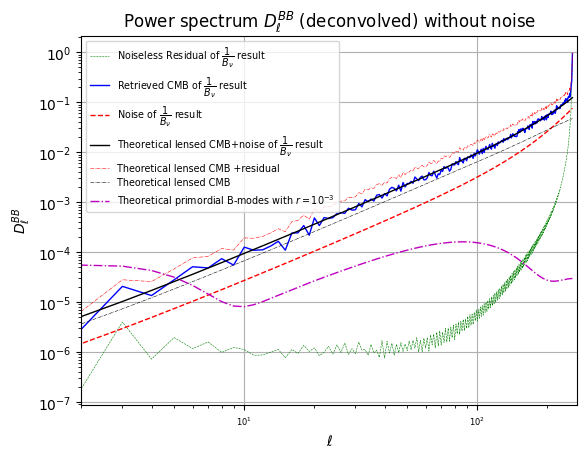

In [83]:
l_arr = np.arange(0,lmax+1,1)

py.figure(1)
ax1 = py.subplot(111)
ax1.tick_params('x', labelsize=6)
ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*C_BB_CMB_inv_l,'g--',linewidth =.4,label = 'Noiseless Residual of $\dfrac{1}{B_{\\nu}}$ result')
ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*C_l_inv_BB,'b',linewidth = 1,label = 'Retrieved CMB of $\dfrac{1}{B_{\\nu}}$ result')
ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*cl_beam_inv[2],'r--',linewidth =1, label = 'Noise of $\dfrac{1}{B_{\\nu}}$ result')
ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*(cl_CMB_crop_th[2]+cl_beam_inv[2]),'k-',linewidth =1,label = "Theoretical lensed CMB+noise of $\dfrac{1}{B_{\\nu}}$ result")
ax1.plot(l_arr,D_ell(C_l_inv_BB+cl_CMB_crop_th[2]),'r-.',linewidth =0.4,label = "Theoretical lensed CMB +residual")

py.title('Power spectrum $D_{\ell}^{BB}$ (deconvolved) without noise')

ax1.plot(l_arr,l_arr*(l_arr+1)*cl_CMB_crop_th[2]/np.pi,'k-.',linewidth =0.4,label = "Theoretical lensed CMB ")

# ax1.plot(l_arr,D_ell(C_l_ren_BB),'b',linewidth = 1,label = 'Retrieved CMB (reconvolved)')
# ax1.plot(l_arr,D_ell(C_BB_CMB_ren_l),'b--',linewidth =.4,label = 'Noiseless Residual of $\dfrac{B_c}{B_{\\nu}}$ result')
# ax1.plot(l_arr,D_ell(cl_beam_ren[2]),'--',color='#F39C12',linewidth =1, label = 'Noise of $\dfrac{B_c}{B_{\\nu}}$ result')
# ax1.plot(l_arr,D_ell((cl_CMB_crop_th[2]*beam_common[:,2]**2)+cl_beam_ren[2]),'k-',linewidth =1,label = "Theoretical Lensed CMB + noise (reconvolved)")
# py.title('Power spectrum $D_{\ell}^{BB}$ (de+reconvolved) with noise')

# ax1.plot(l_arr,np.abs(D_ell(C_l_ren_BB-(cl_CMB_crop_th[2]*beam_common[:,2]**2)+cl_beam_ren[2])),'g',linewidth = 1,label = r'$C_{\ell}^{CMB,ret}-C_{\ell}^{CMB+noise,th}$(result of $\frac{B^c}{B^{\nu}})$')
# ax1.plot(l_arr,D_ell((cl_CMB_crop_th[2]*beam_eff_CMB[:,0,1]**2)+cl_beam_ren[2]),'k-',linewidth =1,label = "Theoretical Lensed CMB + noise (reconvolved)")

# ax1.plot(l_arr,l_arr*(l_arr+1)*(cl_CMB_crop_th[2])*beam_common[:,2]**2/np.pi,'k-.',linewidth =0.4,label = "Theoretical Beamed lensed CMB ")

ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*0.001*cl_GW_crop[2],'m-.',linewidth =1,label = "Theoretical primordial B-modes with $r=10^{-3}$")

# py.title('Harmonic component separation : deconvolved and de+reconvolved')

handles, labels = ax1.get_legend_handles_labels()
py.xlim(left = 2 #,right =2*NSIDE
)

py.grid()
py.xlabel('$\ell$')
py.yscale("log")
py.xscale("log")
# py.ylim(-1,1)

        #  of the residuals with and without beam, with noise')

py.ylabel('$D_{\ell}^{BB}$')  
py.legend(handles,labels, loc = 'upper left', fontsize = 'x-small')
py.show()

Reconvolved

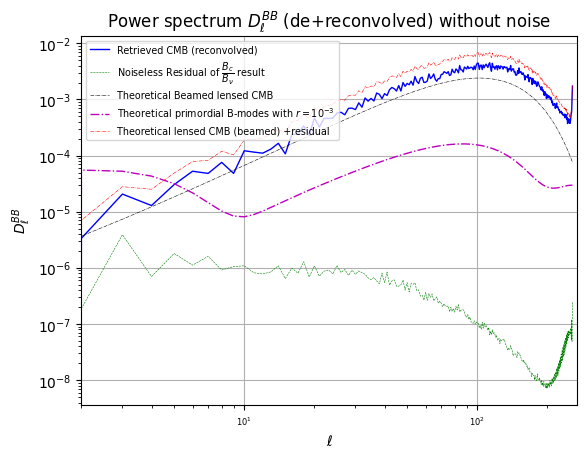

In [84]:
l_arr = np.arange(0,lmax+1,1)

py.figure(1)
ax1 = py.subplot(111)
ax1.tick_params('x', labelsize=6)


ax1.plot(l_arr,D_ell(C_l_ren_BB),'b',linewidth = 1,label = 'Retrieved CMB (reconvolved)')
ax1.plot(l_arr,D_ell(C_BB_CMB_ren_l),'g--',linewidth =.4,label = 'Noiseless Residual of $\dfrac{B_c}{B_{\\nu}}$ result')
# ax1.plot(l_arr,D_ell(cl_beam_ren[2]),'--',color='#F39C12',linewidth =1, label = 'Noise of $\dfrac{B_c}{B_{\\nu}}$ result')
# ax1.plot(l_arr,D_ell((cl_CMB_crop_th[2]*beam_common[:,2]**2)+cl_beam_ren[2]),'k-',linewidth =1,label = "Theoretical Lensed CMB + noise (reconvolved)")
py.title('Power spectrum $D_{\ell}^{BB}$ (de+reconvolved) without noise')

# ax1.plot(l_arr,np.abs(D_ell(C_l_ren_BB-(cl_CMB_crop_th[2]*beam_common[:,2]**2)+cl_beam_ren[2])),'g',linewidth = 1,label = r'$C_{\ell}^{CMB,ret}-C_{\ell}^{CMB+noise,th}$(result of $\frac{B^c}{B^{\nu}})$')
# ax1.plot(l_arr,D_ell((cl_CMB_crop_th[2]*beam_eff_CMB[:,0,1]**2)+cl_beam_ren[2]),'k-',linewidth =1,label = "Theoretical Lensed CMB + noise (reconvolved)")

ax1.plot(l_arr,l_arr*(l_arr+1)*(cl_CMB_crop_th[2])*beam_common[:,2]**2/np.pi,'k-.',linewidth =0.4,label = "Theoretical Beamed lensed CMB ")

ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*0.001*cl_GW_crop[2],'m-.',linewidth =1,label = "Theoretical primordial B-modes with $r=10^{-3}$")
ax1.plot(l_arr,D_ell(C_l_ren_BB+(cl_CMB_crop_th[2])*beam_common[:,2]**2),'r-.',linewidth =0.4,label = "Theoretical lensed CMB (beamed) +residual")

# py.title('Harmonic component separation : deconvolved and de+reconvolved')

handles, labels = ax1.get_legend_handles_labels()
py.xlim(left = 2 #,right =2*NSIDE
)

py.grid()
py.xlabel('$\ell$')
py.yscale("log")
py.xscale("log")
# py.ylim(-1,1)

        #  of the residuals with and without beam, with noise')

py.ylabel('$D_{\ell}^{BB}$')  
py.legend(handles,labels, loc = 'upper left', fontsize = 'x-small')
py.show()

In [85]:
pixel_window=hp.gauss_beam(hp.nside2resol(nside_in),lmax=lmax,pol=True)

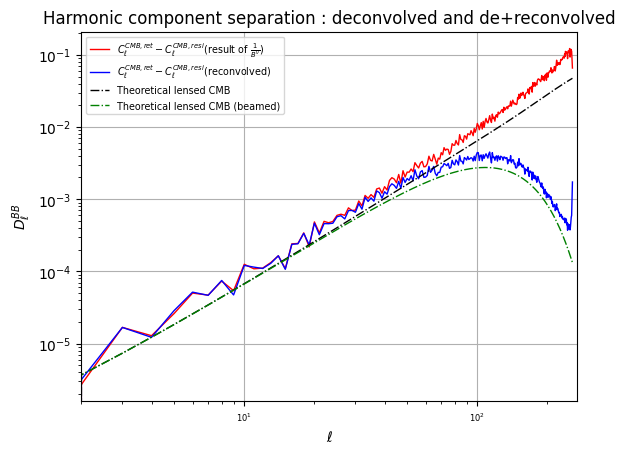

In [86]:
l_arr = np.arange(0,lmax+1,1)

py.figure(1)
ax1 = py.subplot(111)
ax1.tick_params('x', labelsize=6)
ax1.plot(l_arr,D_ell(C_l_inv_BB-C_BB_CMB_inv_l),'r',linewidth = 1,label = r'$C_{\ell}^{CMB,ret}-C_{\ell}^{CMB,resi}$(result of $\frac{1}{B^{\nu}})$')

# py.title('Power spectrum $D_{\ell}^{BB}$ (deconvolved) with noise')

ax1.plot(l_arr,D_ell(C_l_ren_BB-C_BB_CMB_ren_l),'b',linewidth = 1,label = r'$C_{\ell}^{CMB,ret}-C_{\ell}^{CMB,resi}$(reconvolved)')

ax1.plot(l_arr,D_ell(cl_CMB_crop_th[2]),'k-.',linewidth =1,label = "Theoretical lensed CMB ")
ax1.plot(l_arr,D_ell(cl_CMB_crop_th[2]*beam_eff_CMB[:,0,1]**2),'g-.',linewidth =1,label = "Theoretical lensed CMB (beamed)")

        #  $D_{\ell,lens}^{BB}$")
# ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*0.001*cl_GW_crop[2],'m-.',linewidth =1,label = "Theoretical primordial B-modes with $r=10^{-3}$")
# # #         # $D_{\ell,GW}^{BB}$")

py.title('Harmonic component separation : deconvolved and de+reconvolved')

handles, labels = ax1.get_legend_handles_labels()
py.xlim(left = 2 ,#right =2*NSIDE
)

py.grid()
py.xlabel('$\ell$')
py.yscale("log")
py.xscale("log")
# py.ylim(-1,1)

        #  of the residuals with and without beam, with noise')

py.ylabel('$D_{\ell}^{BB}$')  
py.legend(handles,labels, loc = 'upper left', fontsize = 'x-small')
py.show()

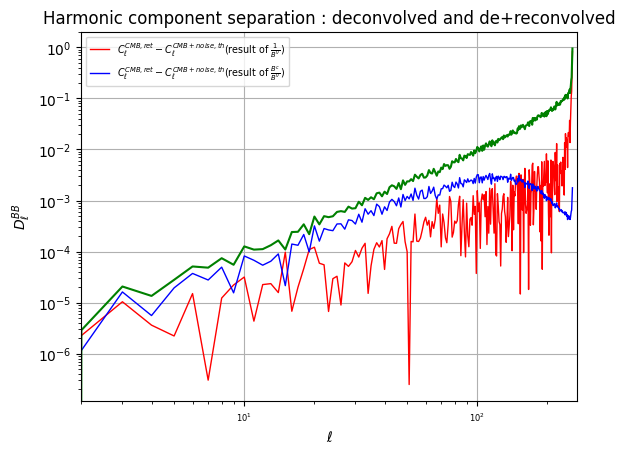

In [87]:
l_arr = np.arange(0,lmax+1,1)

py.figure(1)
ax1 = py.subplot(111)
ax1.tick_params('x', labelsize=6)
ax1.plot(l_arr,np.abs(D_ell(C_l_inv_BB-(cl_CMB_crop_th[2]+cl_beam_inv[2]))),'r',linewidth = 1,label = r'$C_{\ell}^{CMB,ret}-C_{\ell}^{CMB+noise,th}$(result of $\frac{1}{B^{\nu}})$')
ax1.plot(l_arr,np.abs(D_ell(C_l_ren_BB-(cl_CMB_crop_th[2]*beam_common[:,2]**2)+cl_beam_ren[2])),'b',linewidth = 1,label = r'$C_{\ell}^{CMB,ret}-C_{\ell}^{CMB+noise,th}$(result of $\frac{B^c}{B^{\nu}})$')
ax1.plot(l_arr,D_ell(C_l_inv_BB),'g','Retrieved CMB (deconvolved)')
# ax1.plot(l_arr,D_ell(cl_CMB_crop_th[2]+cl_beam_inv[2]))
# ax1.plot(l_arr,D_ell(C_l_inv_BB)-D_ell(cl_CMB_crop_th[2]+cl_beam_inv[2]))


py.title('Harmonic component separation : deconvolved and de+reconvolved')

handles, labels = ax1.get_legend_handles_labels()
py.xlim(left = 2 ,#right =2*NSIDE
)

py.grid()
py.xlabel('$\ell$')
py.yscale("log")
py.xscale("log")
# py.ylim(-1,1)

        #  of the residuals with and without beam, with noise')

py.ylabel('$D_{\ell}^{BB}$')  
py.legend(handles,labels, loc = 'upper left', fontsize = 'x-small')
py.show()

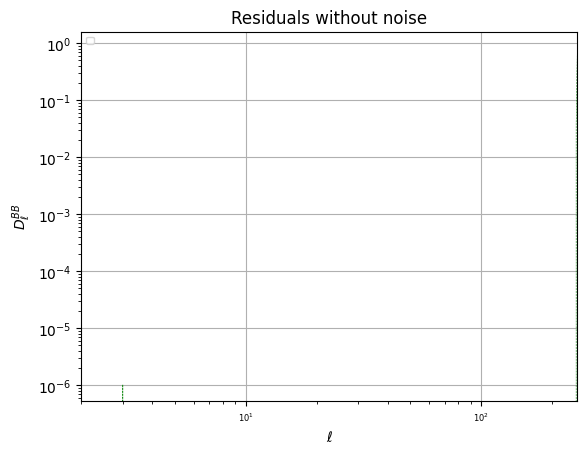

In [88]:
l_arr = np.arange(0,lmax+1,1)

py.figure(1)
ax1 = py.subplot(111)
ax1.tick_params('x', labelsize=6)
ax1.plot(l_arr,D_ell((C_BB_CMB_inv_l-cl_beam_inv[2])),'g--',linewidth =.4# ,label = 'Residual of $\dfrac{1}{B_{\\nu}}$ result')
            )
# ax1.plot(l_arr,D_ell(C_l_inv_BB),'g',linewidth = 1,label = 'Retrieved CMB with pixel window')
# ax1.plot(l_arr,D_ell(C_l_inv_BB*(pixel_window[:,2]**2)),'r',linewidth = 1,label = 'Retrieved CMB without pixel window')
# ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*(cl_CMB_crop_th[2]+cl_beam_inv[2]),'k-',linewidth =1,label = "Theoretical lensed CMB+noise of $\dfrac{1}{B_{\\nu}}$ result")


py.title('Residuals without noise')
# py.title('$\dfrac{1}{B_{\\nu}}$ result')
handles, labels = ax1.get_legend_handles_labels()
py.xlim(left = 2,right = 2*nside_in)
py.grid()
py.xlabel('$\ell$')
py.yscale("log")
py.xscale("log")
# py.ylim(-1,1)

        #  of the residuals with and without beam, with noise')

py.ylabel('$D_{\ell}^{BB}$')  
py.legend(handles,labels, loc = 'upper left', fontsize = 'x-small')
py.show()

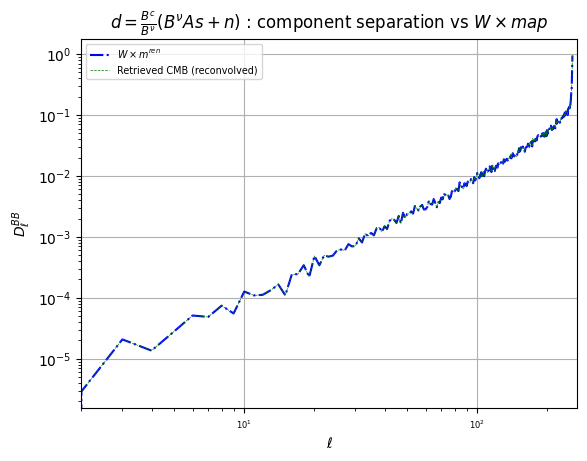

In [89]:
l_arr = np.arange(0,lmax+1,1)

py.figure(1)
ax1 = py.subplot(111)
ax1.tick_params('x', labelsize=6)
# ax1.plot(l_arr,D_ell(resultat_W_cl[0,1]),'b-.', label = r'$W\times m^{ren}$')
# ax1.plot(l_arr,D_ell(C_l_ren_BB),'g--',linewidth =0.5,label = 'Retrieved CMB (reconvolved)')
# ax1.plot(l_arr,D_ell(np.abs(resultat_W_cl[1]-C_l_inv_BB)),'r')
# ax1.plot(l_arr,D_ell(cl_CMB_crop_th[2]+cl_beam_inv[2]))
# ax1.plot(l_arr,D_ell(C_l_inv_BB)-D_ell(cl_CMB_crop_th[2]+cl_beam_inv[2]))
# ax1.plot(l_arr,D_ell(cl_beam_ren[2]),'r--',label = 'Noise after comp sep')
# ax1.plot(l_arr,D_ell(noise_cl_eff[0,1]),'b--',label = r'$W\times m_{noise}$')
# ax1.plot(l_arr,np.abs(D_ell(resultat_W_cl[0,1]-C_l_ren_BB)),'b-.'#, label = r'$W\times m^{ren}$'))


# ax1.plot(l_arr,D_ell(cl_beam_inv[2]),'r--',label = 'Noise after comp sep')
# ax1.plot(l_arr,D_ell(noise_cl_eff_inv[0,1]),'b--',label = r'$W\times m_{noise}$')

ax1.plot(l_arr,D_ell(resultat_W_cl_inv[0,1]),'b-.', label = r'$W\times m^{ren}$')
ax1.plot(l_arr,D_ell(C_l_inv_BB),'g--',linewidth =0.5,label = 'Retrieved CMB (reconvolved)')


py.title(r'$d = \frac{B^c}{B^{\nu}}(B^{\nu}As+n)$ : component separation vs $W\times map$')

handles, labels = ax1.get_legend_handles_labels()
py.xlim(left = 2 ,#right =2*NSIDE
)

py.grid()
py.xlabel('$\ell$')
py.yscale("log")
py.xscale("log")
# py.ylim(-1,1)

        #  of the residuals with and without beam, with noise')

py.ylabel('$D_{\ell}^{BB}$')  
py.legend(handles,labels, loc = 'upper left', fontsize = 'x-small')
py.show()

In [90]:
print(np.where(np.abs(resultat_W_cl[0,1]-C_l_ren_BB)>1e-10))
print(resultat_W_cl[0,1]-C_l_ren_BB)

(array([], dtype=int64),)
[ 0.00000000e+00  0.00000000e+00 -2.00111534e-19  4.15893177e-19
 -1.41030986e-19  2.79944389e-19  1.05032085e-19 -8.72443936e-20
 -1.77453402e-19  6.98802181e-20  4.12505045e-19 -6.43745040e-20
  3.21872520e-20  3.98105485e-20  1.73641754e-20  6.54332952e-20
 -3.51518673e-20  8.89384595e-21 -6.98802181e-20  3.26107685e-20
  3.13402190e-20  9.74087889e-21  6.94567017e-20  2.96461532e-20
  8.04681300e-21  3.98105485e-20  4.23516474e-22 -2.71050543e-20
 -1.56701095e-20 -1.18584613e-20 -4.23516474e-22  2.07523072e-20
  2.28698896e-20 -4.06575815e-20  7.62329653e-21 -2.96461532e-21
 -1.69406589e-21  4.23516474e-22  3.38813179e-21  5.50571416e-21
 -6.77626358e-21 -5.08219768e-21  0.00000000e+00  0.00000000e+00
 -1.01643954e-20  1.27054942e-21  8.47032947e-22  0.00000000e+00
  5.50571416e-21 -5.92923063e-21 -3.38813179e-21 -1.69406589e-21
  4.23516474e-21  4.23516474e-22 -1.65171425e-20  4.23516474e-21
 -2.11758237e-21  5.92923063e-21  0.00000000e+00 -2.75285708e-21

### verifying noise + cmb

In [91]:
print(np.where(cl_CMB[2]+cl_beam_ren<C_l_ren_BB))
print(np.subtract(C_BB_CMB_ren_l,cl_beam_ren))

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]), array([ 2,  3,  4,  5,  6,  7,  8, 10, 11, 13, 16, 17, 18, 19, 20, 23, 29,
       33, 37, 40, 42, 43,  2,  3,  4,  5,  6,  7,  8, 10, 11, 13, 16, 17,
       18, 19, 20, 23, 29, 33, 37, 40, 42, 43,  2,  3,  4,  5,  6,  7,  8,
       10, 11, 13, 16, 17, 18, 19, 20, 23, 29, 33, 37, 40, 42, 43,  2,  3,
        4,  5,  6,  7,  8, 10, 11, 13, 16, 17, 18, 19, 20, 23, 29, 33, 37,
       40, 42, 43]))
[[-7.76920512e-07 -7.76806185e-07 -6.78267192e-07 ... -6.39443423e-09
  -6.15336593e-09 -5.90765706e-09]
 [-7.77149218e-07 -7.77034856e-07 -6.78495796e-07 ... -6.39638926e-09
  -6.15524728e-09 -5.90946719e-09]
 [-7.77149218e-07 -7.77034856e-07 -6.78495796e-07 ... -6.39638926e-09
  -6.15524728e-09 -5.90946719

# Cosmological parameters

In [92]:
def cosmo_likelihood(r,C_l_obs,noise):
    if len(C_l_obs)!=lmax+1 or len(noise)!=lmax+1:
        raise Warning("Arrays should be of size "+str(lmax))
    
    C_lth =r*cl_GW_crop[2]+cl_CMB_crop_th[2]+noise
    sig = 0
    for l in range(2,lmax):
        sig+=((2*l+1)*(np.log(C_lth[l])+C_l_obs[l]/C_lth[l])-(2*l-1)*np.log(C_l_obs[l]))/(-2.)
    return (sig)


In [93]:
def cosmo_likelihood2(r, C_l_obs, noise):
    lmax = len(C_l_obs) - 1
    
    if len(C_l_obs) != lmax + 1 or len(noise) != lmax + 1:
        raise Warning("Arrays should be of size " + str(lmax))
    
    C_lth = r * cl_GW_crop[2,:lmax+1] + cl_CMB_crop_th[2,:lmax+1] + noise
    
    l_values = np.arange(2, lmax)
    sig = np.sum(((2*l_values+1)*(np.log(C_lth[l_values])+C_l_obs[l_values]/C_lth[l_values])-(2*l_values-1)*np.log(C_l_obs[l_values]))/(-2.))
    
    return sig

In [94]:
print(lmax)

256


In [95]:
r_arr = np.logspace(-6,1,100)


In [96]:
test1 = np.array([cosmo_likelihood(r,C_l_obs=C_l_ren_BB,noise=cl_beam_ren[2]) for r in r_arr])

test2 = np.array([cosmo_likelihood2(r,C_l_obs=C_l_ren_BB,noise=cl_beam_ren[2]) for r in r_arr])

In [97]:
import scipy.integrate as spi
import scipy.optimize as spo



def likelihood_integral(delta_r):
    
    
    # Define the likelihood function L(r)
    def L(r):
        return cosmo_likelihood2(r, C_l_obs=C_l_inv_BB, noise=cl_beam_inv[2])
    
    # Define the numerator integrand
    def numerator_integrand(r):
        return L(r)
    
    # Define the denominator integrand
    def denominator_integrand(r):
        return L(r)
    
    # Perform the integrations
    numerator, _ = spi.quad(numerator_integrand, 0, delta_r)
    denominator, _ = spi.quad(denominator_integrand, 0, float('inf'))
    
    # Calculate the ratio and subtract 0.68
    return numerator / denominator - 0.68

# Find the root of the function using the bisection method
delta_r = spo.bisect(likelihood_integral, a=0, b=1e10)  # Adjust the interval [a, b] based on your problem

print("Value of delta r: ", delta_r)

/var/tmp/pbs.172603.idark/ipykernel_109145/50771560.py:23: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  denominator, _ = spi.quad(denominator_integrand, 0, float('inf'))


Value of delta r:  4.447120529155404


In [98]:
from scipy.optimize import minimize

# Define the negative log-likelihood function for minimization
def neg_log_likelihood(r, C_l_obs, noise):
    return -cosmo_likelihood2(r, C_l_obs, noise)

# Define the initial guess for r
r_initial_guess = 1e-6

# Define the observed C_l values and noise array
C_l_obs = C_l_ren_BB/beam_eff[:,2]**2
noise = cl_beam_ren[2]/beam_eff[:,2]**2

# Run the optimization
result_ren = minimize(neg_log_likelihood, r_initial_guess, args=(C_l_ren_BB/beam_eff[:,2]**2, cl_beam_ren[2]/beam_eff[:,2]**2
))
result_inv = minimize(neg_log_likelihood, r_initial_guess, args=(C_l_inv_BB, cl_beam_inv[2]))
# Retrieve the optimized value of r
optimized_r_ren = result_ren.x[0]
optimized_r_inv = result_inv.x[0]

print(r"Bias $\Delta r$ (reconvolved case):", optimized_r_ren)
print(r"Bias $\Delta r$ (deconvolved case):", optimized_r_inv)

Bias $\Delta r$ (reconvolved case): 1.0401534111776831e-05
Bias $\Delta r$ (deconvolved case): 1.0239404419709941e-05


In [99]:
a = test1
b = test2

In [100]:
np.linalg.norm(a - b) / np.linalg.norm(b)

3.4627543009446034e-16

In [101]:
print(np.exp((a[0]-a)/a[0]))
print(np.exp((b[0]-b)/b[0]))

[1.         0.99999978 0.99999953 0.99999922 0.99999887 0.99999845
 0.99999795 0.99999737 0.99999668 0.99999587 0.99999491 0.99999379
 0.99999245 0.99999088 0.99998902 0.99998683 0.99998423 0.99998115
 0.99997751 0.99997319 0.99996808 0.99996201 0.9999548  0.99994625
 0.99993609 0.99992401 0.99990967 0.99989264 0.99987241 0.99984841
 0.99981994 0.99978619 0.99974623 0.99969894 0.99964304 0.99957702
 0.99949909 0.99940717 0.9992988  0.99917108 0.99902058 0.99884323
 0.99863419 0.99838774 0.99809703 0.99775394 0.99734878 0.99687004
 0.99630399 0.99563442 0.99484211 0.99390449 0.99279515 0.99148348
 0.98993427 0.98810748 0.98595818 0.98343662 0.98048863 0.9770562
 0.97307842 0.96849257 0.96323553 0.95724518 0.95046196 0.94283034
 0.93430018 0.92482789 0.91437741 0.90292093 0.89043935 0.87692259
 0.86236971 0.84678888 0.83019737 0.81262142 0.79409623 0.7746659
 0.75438348 0.733311   0.71151949 0.68908888 0.66610775 0.64267278
 0.61888788 0.59486287 0.57071181 0.54655083 0.5224958  0.498659

In [102]:
import timeit

# Define a wrapper function to call cosmo_likelihood
def wrapper1():
    return cosmo_likelihood(r=0, C_l_obs=C_l_ren_BB,noise=cl_beam_ren[2])
def wrapper2():
    return cosmo_likelihood2(r=0, C_l_obs=C_l_ren_BB,noise=cl_beam_ren[2])

# Time the execution of cosmo_likelihood
execution_time1 = timeit.timeit(wrapper1, number=100)
execution_time2 = timeit.timeit(wrapper2, number=100)

print("Execution time 1:", execution_time1, "seconds")
print("Execution time 2:", execution_time2, "seconds")

Execution time 1: 0.05339861288666725 seconds
Execution time 2: 0.0022033415734767914 seconds


In [103]:
l_crop = 150
Cl_ren_crop = (C_l_ren_BB/beam_eff[:,2]**2)[:l_crop]
print(Cl_ren_crop.shape)
noise_ren_crop = (cl_beam_ren[2]/beam_eff[:,2]**2)[:l_crop]
Cl_inv_crop = C_l_inv_BB[:l_crop]
noise_inv_crop_BB = cl_beam_inv[2,:l_crop]

(150,)


In [104]:
noise_ren_crop.shape

(150,)

-9277.359602550912
-9276.238567084603
inv : -9276.238567084603
ren : -9277.359602550912
[-9276.23856708 -9276.23054901 -9276.2312659  -9276.23221043
 -9276.23342158 -9276.23494378 -9276.23682751 -9276.23913007
 -9276.24191631 -9276.24525946 -9276.24924206 -9276.25395691
 -9276.25950816 -9276.26601238 -9276.2735998  -9276.28241557
 -9276.29262109 -9276.30439543 -9276.3179368  -9276.33346409
 -9276.35121849 -9276.37146508 -9276.39449455 -9276.42062491
 -9276.45020323 -9276.4836074  -9276.52124793 -9276.56356968
 -9276.61105369 -9276.6642189  -9276.72362399 -9276.78986911
 -9276.86359768 -9276.94549822 -9277.03630626 -9277.13680624
 -9277.24783365 -9277.37027733 -9277.50508191 -9277.65325076
 -9277.81584916 -9277.99400812 -9278.18892877 -9278.40188753
 -9278.63424217 -9278.88743898 -9279.16302112 -9279.46263845
 -9279.788059   -9280.14118228 -9280.52405469 -9280.9388873
 -9281.38807633 -9281.87422647 -9282.40017763 -9282.96903528
 -9283.58420486 -9284.24943071 -9284.96884008 -9285.7469926

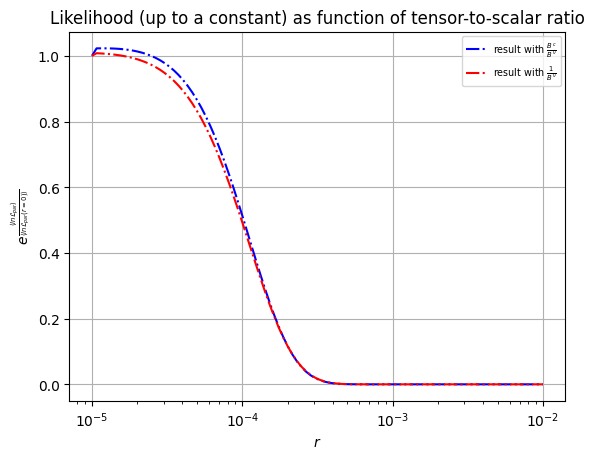

In [105]:
avg_cosmo_ren = cosmo_likelihood2(r=0,C_l_obs=Cl_ren_crop,noise=noise_ren_crop)
avg_cosmo_inv = cosmo_likelihood2(r=0,C_l_obs=Cl_inv_crop,noise=noise_inv_crop_BB)

print(avg_cosmo_ren)
print(avg_cosmo_inv)
r_arr = np.logspace(-5,-2,100)
y_ren =np.array([cosmo_likelihood2(r,C_l_obs=Cl_ren_crop,noise=noise_ren_crop) for r in r_arr])
y_inv =np.array([cosmo_likelihood2(r,C_l_obs=Cl_inv_crop,noise=noise_inv_crop_BB) for r in r_arr])
y_ren[0] = avg_cosmo_ren
y_inv[0] = avg_cosmo_inv

# y_inv0 = np.min(y_inv)
# y_ren0 = np.min(y_ren)
print('inv : '+str(y_inv[0]))
print('ren : '+str(y_ren[0]))
print(y_inv)
fig,ax = py.subplots()

ax.plot(r_arr,np.exp(-(y_ren[0]-y_ren)),'b-.', label = 'result with '+r'$\frac{B^c}{B^{\nu}}$')
ax.plot(r_arr,np.exp(-(y_inv[0]-y_inv)),'r-.',label = 'result with '+r'$\frac{1}{B^{\nu}}$')


# ax.plot(r_arr,-y_ren)
# ax.plot(r_arr,-y_inv)

py.title('Likelihood (up to a constant) as function of tensor-to-scalar ratio')
handles, labels = ax.get_legend_handles_labels()
py.xlabel(r'$r$')
py.ylabel(r'$e^{\frac{\langle ln \mathcal{L}_{par} \rangle}{\langle ln \mathcal{L}_{par}(r=0) \rangle}}$')

# py.ylabel(r'$e^{-1+\frac{\langle ln \mathcal{L}_{par} \rangle}{\langle ln \mathcal{L}_{par}(r=0) \rangle}}$')
# py.yscale("log")
py.xscale("log")
# py.xlim(0,1e-3)
py.grid()
# py.ylim(-1,1)

        #  of the residuals with and without beam, with noise')
# Set the background color of the plot
# ax.set_facecolor('gray')

# Set the background color of the figure
# ax.xaxis.label.set_color('white')
# ax.yaxis.label.set_color('white')
# ax.title.set_color('white')
# fig.set_facecolor('gray')

py.legend(handles,labels, loc = 'best', fontsize = 'x-small')
py.show()

In [106]:
%ls

basic_As+n.ipynb                                       Marco_pix_win/
Brouillon_beam.ipynb                                   Movie.ipynb
Change_resolution.ipynb                                Noiseless/
Cls_Planck2018_lensed_scalar.fits                      Noiseless_CMB_only.mp4
Cls_Planck2018_unlensed_scalar_and_tensor_r1.fits      Noiseless_test.ipynb
componentseparationwithbeam.ipynb                      Notebooks/
deconvolve.ipynb                                       Notes.ipynb
exercise_results.ipynb*                                pix_win.ipynb
Exo1.ipynb                                             platform_node.py
Exo2.ipynb                                             projet.ipynb
fitting.ipynb                                          Pylatex_test.py
Hands_on_likelihood/                                   Transcleaning.ipynb
harmonic_component separation.ipynb                    Transmittance.ipynb
harmonic_comp_sep_with&withoutbeam_change_resol.ipynb  Transmittancev2.ipynb
har

# Harmonic comp sep beam

In [107]:
from fgbuster.separation_recipes import harmonic_comp_sep_beam

In [108]:
from fgbuster.separation_recipes import _A_evaluator_beam

In [109]:
ell = hp.Alm.getlm(lmax, np.arange(num_lm))[0]

ell = np.stack((ell, ell), axis=-1).reshape(-1) # For transformation into real alms
beam_array = np.array([hp.gauss_beam(f,lmax, pol=True) for f in instrument.fwhm*np.pi/(60.*180.)])
beam_array = beam_array[:,:,1:3] ## Only keeping polarization so E & B modes 
num_freq, num_l, num_stokes = beam_array.shape
beam_array_lm = beam_array[:,ell,:]
beam_diag_lm = np.array([[np.diag(beam_array_lm[:,i,j]) for i in range(0,np.size(ell))]for j in range(0,num_stokes)])
beam_diag_lm = np.transpose(beam_diag_lm, (1, 0, 2, 3))

In [110]:
beam_null = np.array([hp.gauss_beam(fwhm,lmax=lmax,pol=True) for fwhm in instrument_null.fwhm])

In [111]:
invN_inv_c = invN(instrument,window=beam_null,num_lm=num_lm,real=False)

/var/tmp/pbs.172603.idark/ipykernel_109145/1226510151.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  nl = np.array([1 / (window[..., i] * np.radians(instrument.depth_p / 60.)[:, np.newaxis]) ** 2 for i in range(4)])


In [112]:
print(invN_inv.shape)

(66306, 4, 15, 15)


In [113]:
A_ev, A_dB_ev, comp_of_param, x0, params = _A_evaluator_beam(components,instrument,beam_diag_lm,lmax)


In [114]:
from fgbuster.separation_recipes import _format_alms,_get_alms

In [115]:
alms = _format_alms(_get_alms(BAS_p, lmax=lmax))

In [116]:
fun, jac, last_values = alg._build_bound_inv_logL_and_logL_dB(A_ev, alms, invN_inv,
                                      A_dB_ev, comp_of_dB=comp_of_param, N_true=None)

In [117]:
print(A_ev(x0).shape)

(66306, 2, 15, 3)


In [118]:
invN_null = invN(instrument_null,window=beam_null,num_lm=num_lm, real = True)
print(invN_null.shape)

/var/tmp/pbs.172603.idark/ipykernel_109145/1226510151.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  nl = np.array([1 / (window[..., i] * np.radians(instrument.depth_p / 60.)[:, np.newaxis]) ** 2 for i in range(4)])


(66306, 4, 15, 15)


In [119]:
result_harmo_beam = harmonic_comp_sep_beam(components,instrument,BAS_p,nside_in,lmax,invN=None,invNlm=invN_null[:,1:3,:,:])

Computing alms


/home/julientang2001/fgbuster/fgbuster/mixingmatrix.py:198: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  res += [g[..., np.newaxis]
/home/julientang2001/fgbuster/fgbuster/algebra.py:1079: RuntimeWarning: invalid value encountered in divide
  res.chi_dB.append(np.sum(res.chi * As_dB_i, -1)


In [120]:
# result_harmo_beam.s = np.array([np.array([hp.almxfl(result_harmo_beam.s[i,j,:],1/pixel_window[:,j+1]) for j in range (2)] )for i in  range(3)])


In [121]:
print(result_harmo_beam.x)

[ 1.54084636 19.96865283 -3.00244295]


In [122]:
A_harmo_beam = A_eval(result_harmo_beam.x)

$W$ matrix

In [123]:
beam_null = np.ones((len(instrument.frequency), lmax+1,4))

In [124]:
W_mat_harmo = alg.W(A_eval(result_harmo_beam.x),invN=invN_l(instrument_null,window=beam_null,lmax=lmax))

/var/tmp/pbs.172603.idark/ipykernel_109145/3573137089.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  nl = np.array([1 / (window[..., i] * np.radians(instrument.depth_p / 60.)[:, np.newaxis]) ** 2 for i in range(4)])


In [125]:
noise_alm_harmo = np.array([hp.map2alm(map_noise,lmax=lmax) for map_noise in freq_map_noise])
noise_alm_harmo_EB = noise_alm_harmo[:,1:3,:]
noise_alm_harmo_EB = noise_alm_harmo_EB.transpose()
print(noise_alm_harmo_EB.shape)
Wlm_harmo = W_mat_harmo[ell_tot,:,:,:]


Wlm_harmo = Wlm_harmo[:,1:3,:,:]
print(Wlm_harmo.shape)

(33153, 2, 15)
(33153, 1, 3, 15)


In [126]:
noise_alm_eff_harmo = _mv(Wlm_harmo,noise_alm_harmo_EB)
print(noise_alm_eff_harmo.shape)
noise_alm_eff_harmo = noise_alm_eff_harmo.swapaxes(0,2)
print(noise_alm_eff_harmo.shape)

(33153, 2, 3)
(3, 2, 33153)


In [127]:
cl_harmo_beam_ren =_get_Cl_noise_nofwhm(instrument=instrument,window = inv_beam_arr, A = A_harmo_beam,lmax=lmax)[i_cmb, i_cmb]
print(cl_harmo_beam_ren.shape)

(4, 257)


/var/tmp/pbs.172603.idark/ipykernel_109145/859232696.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  nl =np.array([(temp[...,i]/np.radians(instrument.depth_p/60.)[:, np.newaxis])**2 for i in range(4)])


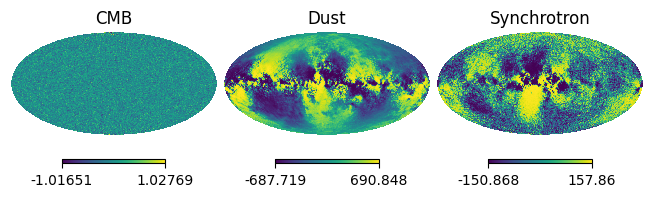

In [128]:
hp.mollview(hp.alm2map(result_harmo_beam.s[0,1],nside_in,lmax), title='CMB', sub=(1,3,1))
hp.mollview(hp.alm2map(result_harmo_beam.s[1,1],nside_in,lmax), title='Dust', norm='hist', sub=(1,3,2))
hp.mollview(hp.alm2map(result_harmo_beam.s[2,1],nside_in,lmax), title='Synchrotron', norm='hist', sub=(1,3,3))


# Residuals
We compare retrieved CMB maps, with input CMB maps.

In [129]:
res_CMB_alm_harmo = result_harmo_beam.s[0,0:2]-alm_CMB[1:3] -noise_alm_eff_harmo[0]


In [130]:
C_l_CMB_harmo=hp.alm2cl(res_CMB_alm_harmo,lmax=lmax)
print(C_l_CMB_harmo.shape)

C_EE_CMB_harmo_l = C_l_CMB_harmo[0]
C_BB_CMB_harmo_l = C_l_CMB_harmo[1]

(3, 257)


We use the maps to retrieve the power spectrum.


In [131]:
C_L_harmo = hp.alm2cl(result_harmo_beam.s[0,0:2],lmax=lmax)
print(C_L_harmo.shape)
C_l_harmo_BB = C_L_harmo[1]
print(C_l_harmo_BB.shape)

(3, 257)
(257,)


# + Gravitational waves
We now want to compare with the power spectrum of gravitational waves

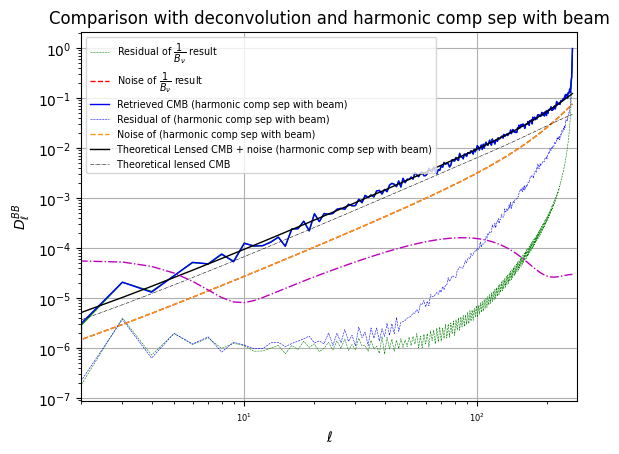

In [132]:
l_arr = np.arange(0,lmax+1,1)

py.figure(1)
ax1 = py.subplot(111)
ax1.tick_params('x', labelsize=6)

ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*C_BB_CMB_inv_l,'g--',linewidth =.4,label = 'Residual of $\dfrac{1}{B_{\\nu}}$ result')
ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*C_l_inv_BB,'g',linewidth = 1
        #  ,         label = 'Retrieved CMB of $\dfrac{1}{B_{\\nu}}$ result'
         )
ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*cl_beam_inv[2],'r--',linewidth =1
         , label = 'Noise of $\dfrac{1}{B_{\\nu}}$ result'
        )
# ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*(cl_CMB_crop_th[2]+cl_beam_inv[2]),'k-',linewidth =1,label = "Theoretical lensed CMB+noise of $\dfrac{1}{B_{\\nu}}$ result")

# # ax1.plot(l_arr,l_arr*(l_arr+1)*cl_CMB_crop_th[2]/np.pi,'k-.',linewidth =0.4,label = "Theoretical lensed CMB ")
# py.title('Power spectrum $D_{\ell}^{BB}$ (deconvolved) with noise')
ax1.plot(l_arr,D_ell(C_l_harmo_BB),'b',linewidth = 1,label = 'Retrieved CMB (harmonic comp sep with beam)')
ax1.plot(l_arr,D_ell(C_BB_CMB_harmo_l),'b--',linewidth =.4
         ,label = 'Residual of (harmonic comp sep with beam)'
        )
ax1.plot(l_arr,D_ell(cl_harmo_beam_ren[2]),'--',color='#F39C12',linewidth =1
         , label = 'Noise of (harmonic comp sep with beam)'
         )
ax1.plot(l_arr,D_ell(cl_CMB_crop_th[2]+cl_harmo_beam_ren[2]),'k-',linewidth =1,label = "Theoretical Lensed CMB + noise (harmonic comp sep with beam)")
py.title('Comparison with deconvolution and harmonic comp sep with beam')
ax1.plot(l_arr,l_arr*(l_arr+1)*cl_CMB_crop_th[2]/np.pi,'k-.',linewidth =0.4,label = "Theoretical lensed CMB ")
        #  $D_{\ell,lens}^{BB}$")
ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*0.001*cl_GW_crop[2],'m-.',linewidth =1#,label = "Theoretical primordial B-modes with $r=10^{-3}$"
         )
# # #         # $D_{\ell,GW}^{BB}$")

# py.title('Harmonic component separation : deconvolved and de+reconvolved')

handles, labels = ax1.get_legend_handles_labels()
py.xlim(left = 2 #,right =2*NSIDE
)

py.grid()
py.xlabel('$\ell$')
py.yscale("log")
py.xscale("log")
# py.ylim(-1,1)

        #  of the residuals with and without beam, with noise')

py.ylabel('$D_{\ell}^{BB}$')  
py.legend(handles,labels, loc = 'upper left', fontsize = 'x-small')
py.show()

In [133]:
avg_cosmo_beam = cosmo_likelihood(r=0,C_l_obs=C_l_harmo_BB,noise=cl_harmo_beam_ren[2])

print(avg_cosmo_beam)

-30397.02992715127


In [134]:
print(C_l_harmo_BB[:l_crop].shape)
print(cl_harmo_beam_ren[2,:l_crop].shape)

(150,)
(150,)


In [135]:
# r_arr = np.logspace(-6,0,100)

y_beam =np.array([cosmo_likelihood2(r,C_l_obs=C_l_harmo_BB[:l_crop],noise=cl_harmo_beam_ren[2,:l_crop]) for r in r_arr])
y_beam0 = cosmo_likelihood2(r=0,C_l_obs=C_l_harmo_BB[:l_crop],noise=cl_harmo_beam_ren[2,:l_crop])

In [136]:
print(y_beam)
print(y_beam0)

[-9276.64723976 -9276.64696587 -9276.64683991 -9276.64689422
 -9276.64716601 -9276.64769798 -9276.648539   -9276.64974477
 -9276.65137869 -9276.65351267 -9276.65622805 -9276.65961663
 -9276.66378173 -9276.66883932 -9276.67491925 -9276.68216656
 -9276.6907428  -9276.7008275  -9276.7126196  -9276.72633907
 -9276.74222845 -9276.76055449 -9276.78160987 -9276.80571486
 -9276.83321906 -9276.86450311 -9276.89998047 -9276.94009912
 -9276.98534328 -9277.03623516 -9277.09333664 -9277.15725097
 -9277.22862453 -9277.30814853 -9277.39656083 -9277.49464783
 -9277.60324645 -9277.72324638 -9277.85559251 -9278.00128768
 -9278.16139593 -9278.33704618 -9278.52943661 -9278.73983981
 -9278.96960882 -9279.22018425 -9279.4931027  -9279.79000662
 -9280.11265571 -9280.46294037 -9280.84289713 -9281.2547265
 -9281.70081346 -9282.18375095 -9282.70636661 -9283.27175322
 -9283.88330318 -9284.54474754 -9285.26020003 -9286.03420659
 -9286.87180114 -9287.77856804 -9288.76071216 -9289.82513717
 -9290.97953309 -9292.232

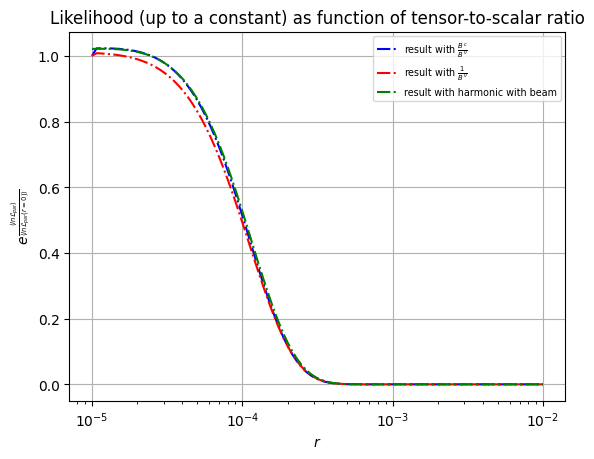

In [137]:


fig,ax = py.subplots()

ax.plot(r_arr,np.exp(-(y_ren[0]-y_ren)),'b-.', label = 'result with '+r'$\frac{B^c}{B^{\nu}}$')
ax.plot(r_arr,np.exp(-(y_inv[0]-y_inv)),'r-.',label = 'result with '+r'$\frac{1}{B^{\nu}}$')
ax.plot(r_arr,np.exp(-(y_beam0-y_beam)),'g-.', label = 'result with harmonic with beam')

# ax.plot(r_arr,np.exp(y_ren),'b-.', label = 'result with '+r'$\frac{B^c}{B^{\nu}}$')
# ax.plot(r_arr,np.exp(y_inv),'r-.',label = 'result with '+r'$\frac{1}{B^{\nu}}$')
# ax.plot(r_arr,np.exp(y_beam),'g-.', label = 'result with harmonic with beam')

# ax.plot(r_arr,-y_ren)
# ax.plot(r_arr,-y_inv)

py.title('Likelihood (up to a constant) as function of tensor-to-scalar ratio')
handles, labels = ax.get_legend_handles_labels()
py.xlabel(r'$r$')
py.ylabel(r'$e^{\frac{\langle ln \mathcal{L}_{par} \rangle}{\langle ln \mathcal{L}_{par}(r=0) \rangle}}$')

# py.ylabel(r'$e^{-1+\frac{\langle ln \mathcal{L}_{par} \rangle}{\langle ln \mathcal{L}_{par}(r=0) \rangle}}$')
# py.yscale("log")
py.xscale("log")
# py.xlim(0,1e-3)
py.grid()
# py.ylim(-1,1)

        #  of the residuals with and without beam, with noise')
# Set the background color of the plot
# ax.set_facecolor('gray')

# Set the background color of the figure
# ax.xaxis.label.set_color('white')
# ax.yaxis.label.set_color('white')
# ax.title.set_color('white')
# fig.set_facecolor('gray')

py.legend(handles,labels, loc = 'best', fontsize = 'x-small')
py.show()

In [138]:
from scipy.optimize import minimize

# Define the negative log-likelihood function for minimization
def neg_log_likelihood(r, C_l_obs, noise):
    return -cosmo_likelihood2(r, C_l_obs, noise)

# Define the initial guess for r
r_initial_guess = 1e-6

y_beam =np.array([cosmo_likelihood2(r,C_l_obs=C_l_harmo_BB,noise=cl_harmo_beam_ren[2]) for r in r_arr])

# Run the optimization
result_ren = minimize(neg_log_likelihood, r_initial_guess, args=(C_l_harmo_BB/beam_common[:,2]**2, cl_harmo_beam_ren[2]/beam_common[:,2]**2
))
# Retrieve the optimized value of r
optimized_r_ren = result_ren.x[0]
optimized_r_inv = result_inv.x[0]

print(r"Bias $\Delta r$ (reconvolved case):", optimized_r_ren)
print(r"Bias $\Delta r$ (deconvolved case):", optimized_r_inv)

Bias $\Delta r$ (reconvolved case): 0.015096331182508992
Bias $\Delta r$ (deconvolved case): 1.0239404419709941e-05


In [139]:
from scipy.optimize import root_scalar
from scipy.optimize import newton

# Define the derivative of the cosmo_likelihood function with respect to r
def derivative_cosmo_likelihood(r, C_l_obs, C_lth):
    eps = 1e-3 # Small epsilon value for numerical differentiation
    return (cosmo_likelihood2(r + eps, C_l_obs, C_lth) - cosmo_likelihood2(r - eps, C_l_obs, C_lth)) / (2 * eps)

# Define the inputs to cosmo_likelihood function
C_l_obs = C_l_harmo_BB/beam_common[:,2]**2
C_lth = cl_harmo_beam_ren[2]/beam_common[:,2]**2

# Define the objective function for root finding
def objective(r, C_l_obs, C_lth):
    return derivative_cosmo_likelihood(r, C_l_obs, C_lth)

# # Use root_scalar to find the root (zero) of the objective function
# result = root_scalar(objective, args=(C_l_obs, C_lth), method='brentq')

# # Check if the optimization was successful
# if result.converged:
#     delta_r = result.root
#     print("Value of Δr:", delta_r)
# else:
#     print("Optimization did not converge.")

# Use newton to find the root (zero) of the objective function
result = newton(objective, x0=1.0, args=(C_l_obs, C_lth))

delta_r = result
print("Value of Δr:", delta_r)


RuntimeError: Failed to converge after 50 iterations, value is 147061980166.6984.

FGBuster is a parametric maximum lilkelihood based component separation

$d=A(\beta)s+n \text{ with } \beta$ spectral likelihood parameters

full data likelihood $-2\ln{\mathcal{L}_{data}}=C+(d-As)^TN^{-1}(d-AS)$

The spectral likelihood gives the maximum value of the data likelihood for any chosen value of the spectral parameters
$-2\ln{\mathcal{L}_{spec}}=C-(A^TN^{-1}d)^T(A^TN^{-1}A)^{-1}(A^TN^{-1}d)$

basic comp sep : one set of spectral paramters only on the whole sky
spectral likelihood maximized mine scipy.optimize.minimize()

Likelihood model : start with only GW, no noise 

In [ ]:
def cosmo_likelihood_nl(r, C_l_obs):
    lmax = len(C_l_obs) - 1
    
    if len(C_l_obs) != lmax + 1 or len(noise) != lmax + 1:
        raise Warning("Arrays should be of size " + str(lmax))
    
    C_lth = r * cl_GW_crop[2,:lmax+1]
    
    l_values = np.arange(2, lmax)
    sig = np.sum(((2*l_values+1)*(np.log(C_lth[l_values])+C_l_obs[l_values]/C_lth[l_values])-(2*l_values-1)*np.log(C_l_obs[l_values]))/(-2.))
    
    return sig

In [ ]:
r0 = 1e-6
C_l_obs_nl = r0*cl_GW_crop[2,:lmax+1]
r_arr2 = np.linspace(1e-7,1e-5,100)


In [ ]:
cosmo_nl_0 = cosmo_likelihood_nl(r0,C_l_obs_nl)
cosmo_nl = np.array([cosmo_likelihood_nl(r,C_l_obs_nl) for r in r_arr2])

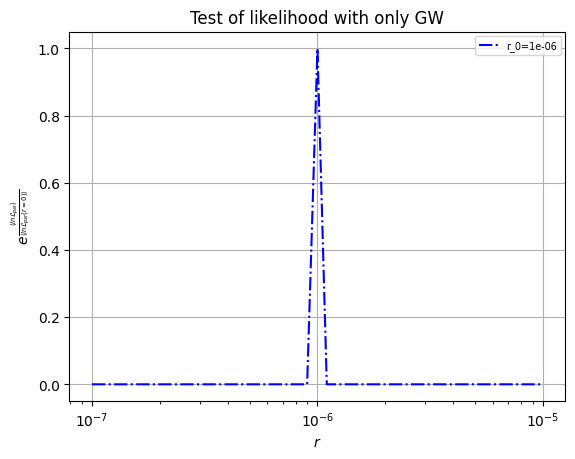

In [ ]:


fig,ax = py.subplots()

ax.plot(r_arr2,np.exp(-(cosmo_nl_0-cosmo_nl)),'b-.', label = r'r_0='+str(r0))


py.title('Test of likelihood with only GW')
handles, labels = ax.get_legend_handles_labels()
py.xlabel(r'$r$')
py.ylabel(r'$e^{\frac{\langle ln \mathcal{L}_{par} \rangle}{\langle ln \mathcal{L}_{par}(r=0) \rangle}}$')

# py.ylabel(r'$e^{-1+\frac{\langle ln \mathcal{L}_{par} \rangle}{\langle ln \mathcal{L}_{par}(r=0) \rangle}}$')
# py.yscale("log")
py.xscale("log")
# py.xlim(0,1e-3)
py.grid()
# py.ylim(-1,1)

        #  of the residuals with and without beam, with noise')
# Set the background color of the plot
# ax.set_facecolor('gray')

# Set the background color of the figure
# ax.xaxis.label.set_color('white')
# ax.yaxis.label.set_color('white')
# ax.title.set_color('white')
# fig.set_facecolor('gray')

py.legend(handles,labels, loc = 'best', fontsize = 'x-small')
py.show()